In [30]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import hydra
import torch
from omegaconf import DictConfig, OmegaConf

from sklearn.manifold import TSNE # new
from sklearn.decomposition import PCA
import seaborn as sns

from src.commons.utils_io import load_sam, make_path, check_dir
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.loader import BiTemporalDataset
from src.data.process import generate_grid_prompt, DefaultTransform
from src.models.magic_pen.task import MagicPenModule
from src.models.segment_any_change.model import BiSam
from src.models.segment_any_change.mask_generator import SegAnyMaskGenerator
from src.models.commons.mask_items import ImgType


In [65]:
from torch.nn.utils.rnn import pad_sequence
from src.models.commons.mask_process import extract_object_from_batch

In [3]:
def load_config():
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../configs", version_base=None)
    
    # Compose the configuration with the desired environment override
    cfg = hydra.compose(
        config_name="eval", 
        overrides=["experiment=seganychange_matching", 
                   "sam_type=small", 
                   "data=levir-cd",
                  ])
    
    return cfg
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
cfg = load_config()

In [12]:
cfg.sam_enc_arch

'vit-b'

In [8]:
dict(cfg.model.instance.model)

{'_target_': 'src.models.segment_any_change.matching.BitemporalMatching',
 'th_change_proposals': 60,
 'col_nms_threshold': 'ci',
 'sam_ckpt_path': '/var/data/usr/mdizier/stylo_magique/checkpoints/sam/sam_vit_b_01ec64.pth',
 'network': {'image_encoder': {'_target_': 'src.models.segment_anything.modeling.image_encoder_dev.ImageEncoderViT', 'depth': 12, 'embed_dim': 768, 'img_size': 1024, 'mlp_ratio': 4, 'norm_layer': None, 'num_heads': 12, 'patch_size': 16, 'qkv_bias': True, 'use_rel_pos': True, 'global_attn_indexes': [2, 5, 8, 11], 'window_size': 14, 'out_chans': 256}, 'prompt_encoder': {'_target_': 'src.models.segment_anything.modeling.prompt_encoder_dev.PromptEncoder', 'embed_dim': 256, 'image_embedding_size': [64, 64], 'input_image_size': [1024, 1024], 'mask_in_chans': 16}, 'mask_decoder': {'transformer': {'_target_': 'src.models.segment_anything.modeling.transformer_dev.TwoWayTransformer', 'depth': 2, 'embedding_dim': 256, 'mlp_dim': 2048, 'num_heads': 8}, '_target_': 'src.models.s

In [26]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":3,
    "loc": "center",
    "batch_size": 2,
}


sam_kwargs = {
    "sam_ckpt_path":'/var/data/usr/mdizier/stylo_magique/checkpoints/sam/sam_vit_b_01ec64.pth',
    'pred_iou_thresh': 0.8,
     'stability_score_thresh': 0.8,
     'stability_score_offset': 1.0,
     'box_nms_thresh': 0.7,
     'min_mask_region_area': 0,
     'mask_threshold': 0
}

indices = [12, 13]

# ds = BiTemporalDataset(
#             name="levir-cd",
#             dtype="test",
#             transform=DefaultTransform(),
#             params=OmegaConf.create(params),
#         )

# subset = torch.utils.data.Subset(ds, indices)

# dloader = data.DataLoader(
#             subset,
#             batch_size=params.get('batch_size'),
#             shuffle=False,
#             num_workers=0,
#         )

def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

In [27]:
data_module = hydra.utils.instantiate(cfg.data)
dloader = get_dloader("test", data_module)

In [28]:
batch = next(iter(dloader))

In [29]:
batch["point_coords"].shape

torch.Size([2, 1024, 2])

In [19]:
# seganychange model
sam_arch = cfg.sam_enc_arch.replace("-", "_")
bisam = load_sam(
    model_type=sam_arch, model_cls=BiSam, version= "dev", device="cpu"
)

2024-08-22 16:45:12,785 - INFO ::  build vit_b BiSam


INIT VIT


In [22]:
# seganychange model - matching
mask_generator = SegAnyMaskGenerator(
    model=bisam,
    **sam_kwargs
)

In [31]:
img_anns = mask_generator.generate(batch)

sparse_embeddings: torch.Size([4, 1024, 2, 256])
dense_embeddings: torch.Size([4, 1024, 256, 64, 64])
OUT MODEL : torch.Size([4, 1024, 3, 256, 256])
ATTACH 179 masks
ATTACH 228 masks
ATTACH 189 masks
ATTACH 253 masks


In [47]:
img_anns[0].keys()

dict_keys(['masks', 'masks_logits', 'bbox', 'predicted_iou', 'img_type'])

In [63]:
img_anns[1]["masks"].shape

torch.Size([228, 256, 256])

In [64]:
img_anns[3]["masks"].shape

torch.Size([253, 256, 256])

In [160]:
mask_batch = pad_sequence([m["masks"] for m in img_anns if m["img_type"] == ImgType.B], batch_first=True)
label_batch = extract_object_from_batch(batch["label"])

In [73]:
label_batch.shape

torch.Size([2, 60, 1024, 1024])

### Remove labels object from batch

On souhaite extraire les objets qui ne sont pas des batiments. On fait l'approximation que les batiments de changement ~ batiments. On filtrera si necessaire

In [97]:
backgrd_obj_batch = []
rejected_obj_batch = []
mask_batch_ = resize(mask_batch, label_batch.shape[-2:])
for i, item in enumerate(mask_batch_):
    label_i = torch.sum(label_batch[i], dim=0)
    backgrd_obj = []
    rejected_obj = []
    for mask in mask_batch_[i]:
        if not torch.sum((torch.logical_and(mask, label_i))):
            backgrd_obj.append(mask)
        else:
            rejected_obj.append(mask)
    
    backgrd_obj_batch.append(torch.stack(backgrd_obj) if backgrd_obj else torch.zeros(1, 1024, 1024))
    rejected_obj_batch.append(torch.stack(rejected_obj) if rejected_obj else torch.zeros(1, 1024, 1024))

backgrd_obj_batch = pad_sequence(backgrd_obj_batch, batch_first=True)
rejected_obj_batch = pad_sequence(rejected_obj_batch, batch_first=True)

In [99]:
rejected_obj_batch.shape

torch.Size([2, 90, 1024, 1024])

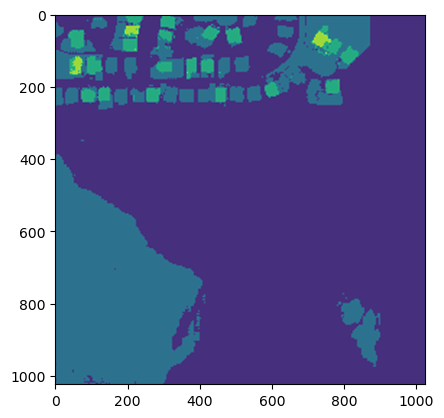

In [156]:
plt.imshow(torch.sum(rejected_obj_batch[1], dim=0))

Il peut y avoir de l'overlap dans les masques background...

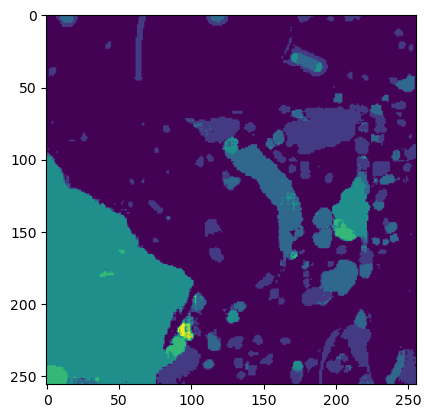

In [157]:
plt.imshow(torch.sum(backgrd_obj_batch[1], dim=0))

In [159]:
label_batch.shape

torch.Size([2, 60, 256, 256])

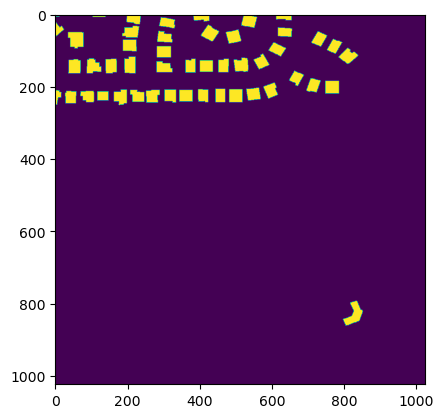

In [158]:
plt.imshow(batch["label"][1])

In [98]:
backgrd_obj_batch.shape

torch.Size([2, 232, 1024, 1024])

In [110]:
from models.segment_any_change.embedding import (
    _compute_mask_embedding_batch_torch,
_compute_mask_embedding_torch,
    get_img_embedding_normed,
)

imgs_embedding = get_img_embedding_normed(
    mask_generator.model, ImgType.B
)

In [113]:
imgs_embedding.shape

torch.Size([2, 256, 64, 64])

In [161]:
# memory compute
backgrd_obj_batch = resize(backgrd_obj_batch, (256, 256))
label_batch = resize(label_batch, (256, 256))

In [115]:
label_batch.shape

torch.Size([2, 60, 256, 256])

In [162]:
label_embedding = _compute_mask_embedding_batch_torch(label_batch, imgs_embedding)

In [163]:
backgrd_obj_embedding = _compute_mask_embedding_batch_torch(backgrd_obj_batch, imgs_embedding)

In [164]:
backgrd_obj_embedding.shape

torch.Size([2, 232, 256])

In [236]:
idx = 1
back_emb = backgrd_obj_embedding[idx]
label_emb = label_embedding[idx]

In [237]:
back_emb = pd.DataFrame(back_emb)
label_emb = pd.DataFrame(label_emb)
back_emb["label"] = 0
label_emb["label"] = 1

In [238]:
tsne = TSNE(n_components=2, perplexity=5)

In [239]:
data = pd.concat([back_emb.dropna(), label_emb.dropna()]).sample(frac=1)

In [240]:
data.shape

(211, 257)

In [241]:
out = tsne.fit_transform(data.drop("label", axis=1))

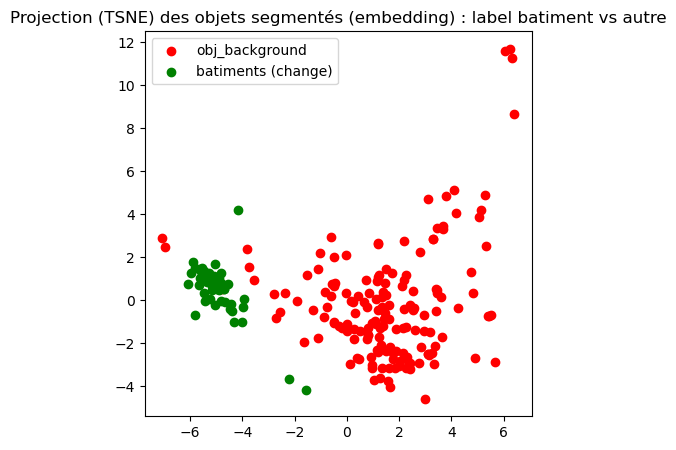

In [257]:
fig, ax = plt.subplots(figsize=(5, 5))

red = data["label"] == 0
green = data["label"] == 1

ax.scatter(out[red, 0], out[red, 1], c="r", label="obj_background")
ax.scatter(out[green, 0], out[green, 1], c="g", label="batiments (change)")
ax.set_title("Projection (TSNE) des objets segmentés (embedding) : label batiment vs autre")
plt.legend()

Les points non-batiments proche du cluster batiments sont il des batiments de non-changements ?

In [251]:
pca = PCA(n_components=2)

In [252]:
out = pca.fit_transform(data.drop("label", axis=1))

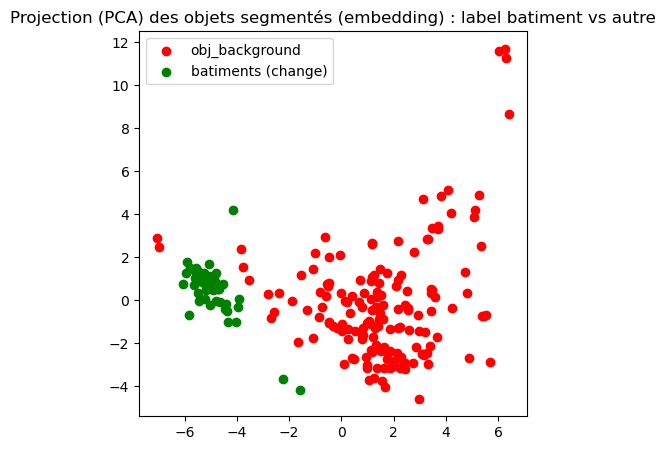

In [255]:
fig, ax = plt.subplots(figsize=(5, 5))

red = data["label"] == 0
green = data["label"] == 1

ax.scatter(out[red, 0], out[red, 1], c="r", label="obj_background")
ax.scatter(out[green, 0], out[green, 1], c="g", label="batiments (change)")
ax.set_title("Projection (PCA) des objets segmentés (embedding) : label batiment vs autre")
plt.legend()

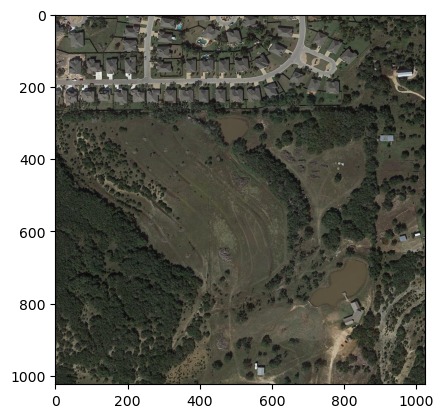

In [248]:
idx = 1
plt.imshow(batch["img_B"][idx].permute(1, 2, 0)/255)

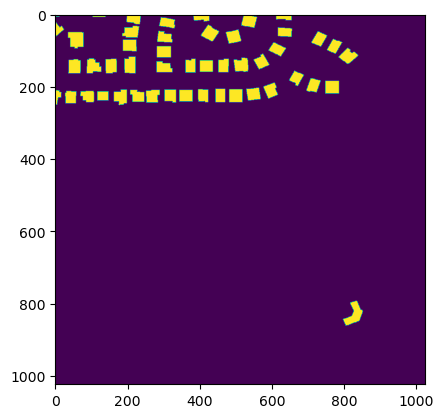

In [249]:
plt.imshow(batch["label"][idx])

In [ ]:
imgs_embedding_B = get_img_embedding_normed(
    mask_generator.model, ImgType.B
)